### Perimeter Institute Nov 23rd
### 2018 computational physics course
# Exact Diagonalization
 
Guifre Vidal  

# IJulia nb4: quantum entanglement

In [3]:
using PyPlot
using LinearAlgebra
using Arpack

In [4]:
Psi = randn(6) + im*randn(6) # complex vector

6-element Array{Complex{Float64},1}:
 -1.0628211930185867 + 3.7582299766274283im 
 -0.6671223192696618 - 1.505781790901663im  
  -1.424755712503474 - 0.6693549772722557im 
 -0.5052810121957295 - 1.3203229246796055im 
 0.31735715100567324 - 0.04520142414086508im
 -0.9875028869967035 + 0.4364784125635265im 

In [5]:
Psi'*Psi # already just a complex number! (not an array)

23.711272975359275 + 0.0im

In [6]:
Psi = Psi/sqrt(abs(Psi'*Psi))  # normalized vector
Psi'*Psi

1.0000000000000002 + 0.0im

In [7]:
PsiAB = reshape(Psi, (3,2)) # bipartite vector

3×2 Array{Complex{Float64},2}:
 -0.218264+0.771802im  -0.103766-0.271146im  
 -0.137002-0.309232im  0.0651735-0.00928271im
 -0.292592-0.137461im  -0.202797+0.0896366im 

In [8]:
rdmA = PsiAB*PsiAB' # reduced density matrix for part A
rdmB = PsiAB'*PsiAB # reduced density matrix for part B
(size(PsiAB), size(rdmA), size(rdmB))

((3, 2), (3, 3), (2, 2))

In [9]:
tr(rdmA) # checking that the trace is 1

1.0000000000000002 + 0.0im

### 1) Given a bipartite wavefunction $\Psi_{AB}$, compute the reduced density matrix $\rho_A \equiv \mbox{Tr}_B(\left|\Psi_{AB}\rangle \langle \Psi_{AB}\right|)$ 

In [10]:
function compute_rdmA(PsiAB)
    @assert ndims(PsiAB) == 2 # did we input a matrix?
    @assert size(PsiAB,1) < 2^13 # make sure the resulting matrix is not too large!
    rdm = PsiAB*PsiAB'
end

nA = 4 # number spins/qubits in A
nB = 5 # number of spins/qubits in B
Psi = randn(2^(nA+nB)) + im*randn(2^(nA+nB))
Psi = Psi/sqrt(Psi'*Psi) 
PsiAB = reshape(Psi, (2^(nA),2^(nB)))
rdmA = compute_rdmA(PsiAB)
eigvals(rdmA)


16-element Array{Float64,1}:
 0.00883168828727382 
 0.013958842374827975
 0.017931727477443433
 0.022452254737674638
 0.029736609027394414
 0.0392657430384324  
 0.04136933103094236 
 0.04913131294877505 
 0.05972979128900736 
 0.07029279344988208 
 0.08165525238149082 
 0.0910630300035694  
 0.0976742747495661  
 0.1116711911946861  
 0.12385748033668481 
 0.1413786776723493  

### 2) Given $\rho_A$, compute its entropy

In [11]:
function compute_entropy(dm)
    p = eigvals(dm)
    entropy = 0.0
    #entropy = - p'*log2.(p) # problems when p[n] is of order 0 (possibly negative)
    for n in 1:size(p,1)
        if abs(p[n]) > 1e-12
            entropy = entropy - p[n]*log2(p[n])
        end
    end
    entropy
end

compute_entropy(rdmA)

3.6863872591541513

### 3) Given $|\Psi\rangle$ of $N$ spins, compute the entropy of the reduced density matrix on $n=1,2,\cdots,N/2$ spins 

In [17]:
function compute_entropies(Psi)
    @assert ndims(Psi) == 1 
    N = floor(Int64,log2(size(Psi,1) + 1e-5))    
    Nmin = 1
    Nmax = floor(Int64,N/2) # N/2 for even N, (N-1)/2 for odd N
    entropies = zeros(Nmax-Nmin+1)
    for nA in Nmin:Nmax
        PsiAB = reshape(Psi, (2^(nA),2^(N-nA)))
        rdmA = compute_rdmA(PsiAB)
        entropies[nA] = compute_entropy(rdmA)
    end
    entropies
end


compute_entropies (generic function with 1 method)

### 4) for $N$ spins ($N \geq 12$) create ground state of Ising model at critical point, as well as a random state

In [15]:
function buildH(N::Int64,theta::Float64)::Array{Float64,2} 
    X = [0. 1; 1 0]
    Z = [1. 0; 0 -1]
    E = diagm(0=>ones(2))
    XX = kron(X,X)
    HXX = XX
    HZ = kron(Z,E) + kron(E,Z)
    for n = 3:N
        HXX = kron(HXX,E)+kron(diagm(0=>ones(2^(n-2))), XX)
        HZ =  kron(HZ,E) + kron(diagm(0=>ones(2^(n-1))),Z)
    end
    HXX = HXX + kron(X,kron(diagm(0=>ones(2^(N-2))),X))
    H = -cos(theta)*HXX - sin(theta)*HZ
    return H
end

buildH (generic function with 1 method)

In [16]:
N = 12 # number of qubits/spins N=14 OK

# ground state crit
H = buildH(N,pi/4)
@time D,U = eigs(H,nev=1,which=:SR)
PsiIsingCrit = U[:,1]

# ground state crit
H = buildH(N,pi/3)
@time D,U = eigs(H,nev=1,which=:SR)
PsiIsing2 = U[:,1]
H=0 # to free memory?

# random state
PsiRand = randn(2^N) + im*randn(2^N)
PsiRand = PsiRand/sqrt(abs(PsiRand'*PsiRand));

  0.711629 seconds (428 allocations: 821.313 KiB)
  0.671714 seconds (388 allocations: 819.750 KiB)


### 5) Both for the ground state (with $\theta = \pi/2$ and $\theta = \pi/3$) and a random state, compute and plot the entropy as a function of $n_A=1,2,\cdots N/2$, 

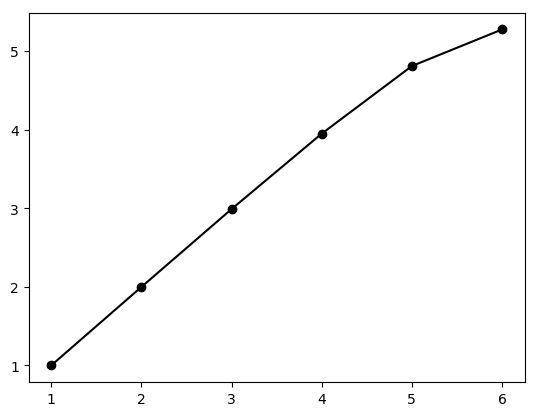

In [20]:
entropiesRand = compute_entropies(PsiRand)
entropiesIsingCrit = compute_entropies(PsiIsingCrit)
entropiesIsing2 = compute_entropies(PsiIsing2)
# Rand entropies
plot(collect(1:size(entropiesRand,1)),entropiesRand, marker = "o", color = "k");

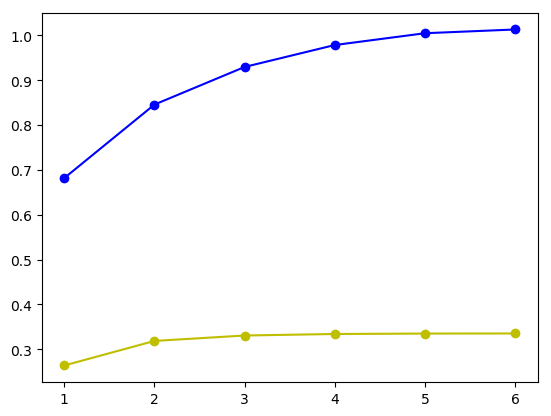

In [21]:
# Ising Entropies
plot(collect(1:size(entropiesIsingCrit,1)),entropiesIsingCrit, marker = "o", color = "b");
plot(collect(1:size(entropiesIsing2,1)),entropiesIsing2, marker = "o", color = "y");

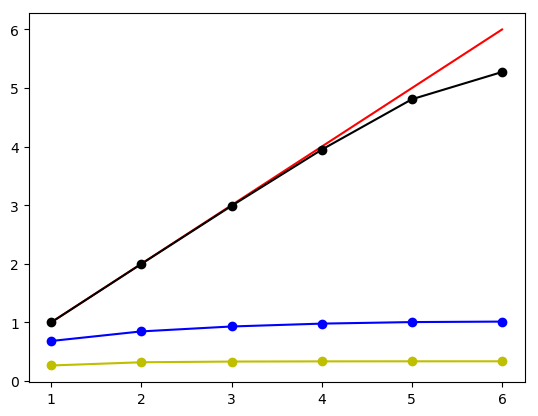

In [22]:
plot(collect(1:size(entropiesRand,1)),collect(1:size(entropiesRand,1)), color = "r")
plot(collect(1:size(entropiesRand,1)),entropiesRand, marker = "o", color = "k")
plot(collect(1:size(entropiesIsingCrit,1)),entropiesIsingCrit, marker = "o", color = "b");
plot(collect(1:size(entropiesIsing2,1)),entropiesIsing2, marker = "o", color = "y");